정규화(Normalization)를 위한 빈 도파로 측정을 시작합니다...
🎯 계산된 순수 입력 에너지(P_in): 15.024357


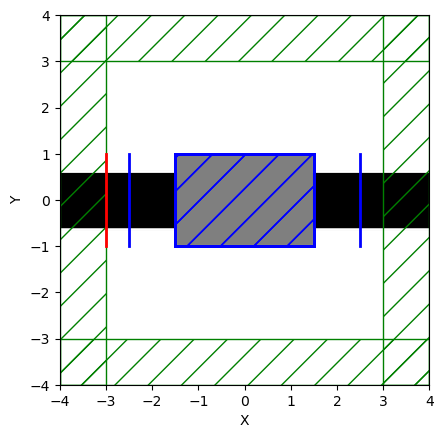

In [ ]:
## mode converter ##
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import grad as ag_grad
import nlopt
import matplotlib.pyplot as plt

mp.verbosity(0)

Si = mp.Medium(index=3.4)

resolution = 40

# cell size
Sx = 8
Sy = 8
cell_size = mp.Vector3(Sx, Sy, 0)
pml_layers = [mp.PML(1.0)]
 

# source
fcen = 1 / 0.75 # 750nm
width = 0.2
fwidth = width * fcen
source_center = [-3, 0, 0]
source_size = mp.Vector3(0, 2, 0)
src = mp.GaussianSource(frequency = fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        eig_match_freq=True,
        direction=mp.X,
        size=source_size,
        center=source_center,
        eig_parity=mp.ODD_Z
    )
]


# design region
Dx = 3
Dy = 2
design_region_resolution = int(resolution)

Nx = int(Dx * design_region_resolution + 1)
Ny = int(Dy * design_region_resolution + 1)

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny),
                                   mp.air,
                                   Si,
                                   grid_type="U_MEAN")
design_region = mpa.DesignRegion(design_variables,
                                 volume=mp.Volume(center=mp.Vector3(),
                                                  size=mp.Vector3(Dx, Dy)))


# geometry 
geometry = [
    mp.Block(
            center=mp.Vector3(-2.75, 0),
            material=Si,
            size=mp.Vector3(2.5, 1.2, 0)
            ),
    mp.Block(
            center=mp.Vector3(2.75, 0),
            material=Si,
            size=mp.Vector3(2.5, 1.2, 0)
            ),
    mp.Block(
            center=design_region.center,
            material=design_variables,
            size=design_region.size
            )
]


# border mask
design_region_width  = Dx
design_region_height = Dy
waveguide_width = 1.2

x_g = np.linspace(-design_region_width/2,  design_region_width/2,  Nx)
y_g = np.linspace(-design_region_height/2, design_region_height/2, Ny)

border_mask = np.zeros((Nx, Ny), dtype=bool)
border_mask[0, :]  = True
border_mask[-1, :] = True
border_mask[:, 0]  = True
border_mask[:, -1] = True

Si_mask = np.zeros((Nx, Ny), dtype=bool)
port_cols = np.abs(y_g) <= waveguide_width/2
Si_mask[0,  port_cols] = True
Si_mask[-1, port_cols] = True

Air_mask = border_mask.copy()
Air_mask[Si_mask] = False


# filter
filter_radius = 0.08 # 80nm
eta_i = (0.5)
eta_e = 0.55
eta_d = 1 - eta_e

def mapping(x, beta, eta):
    x_reshaped = npa.reshape(x, (Nx, Ny))

    # apply border mask
    x_reshaped = npa.where(Si_mask, 1.0, x_reshaped)
    x_reshaped = npa.where(Air_mask, 0.0, x_reshaped)

    # cone shaped filter
    x_filtered = mpa.conic_filter(
        x_reshaped, 
        filter_radius, 
        design_region.size.x,
        design_region.size.y,
        design_region_resolution
    )

    # projection
    x_proj = mpa.tanh_projection(x_filtered, beta, eta)

    return x_proj.flatten()



# simulation
sim =mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    eps_averaging=False,
    resolution=resolution,
)

TE00 = mpa.EigenmodeCoefficient(
    sim,
    mp.Volume(center=mp.Vector3(-2.5,0,0), size=mp.Vector3(y=2)),
    mode=1,
    forward=False,
    eig_parity=mp.ODD_Z

)

TE20 = mpa.EigenmodeCoefficient(
    sim,
    mp.Volume(center=mp.Vector3(2.5,0,0), size=mp.Vector3(y=2)),
    mode=3,
    eig_parity=mp.ODD_Z
)

ob_list = [TE00, TE20]


# initial energy 
def get_input_flux():
    print("정규화(Normalization)를 위한 빈 도파로 측정을 시작합니다...")
    
    straight_geometry = [
        mp.Block(
            center=mp.Vector3(0, 0),
            material=Si,
            size=mp.Vector3(mp.inf, waveguide_width, 0)
        )
    ]
    
    sim_straight = mp.Simulation(
        cell_size=cell_size,
        boundary_layers=pml_layers,
        geometry=straight_geometry,
        sources=source,
        resolution=resolution,
    )
    
    mon_vol = mp.Volume(center=mp.Vector3(2.0, 0, 0), size=mp.Vector3(y=2))
    mon = sim_straight.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=mon_vol))
    
    sim_straight.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(2.0, 0, 0), 1e-5))
    
    res = sim_straight.get_eigenmode_coefficients(mon, [1], eig_parity=mp.ODD_Z)
    calculated_p_in = np.abs(res.alpha[0, 0, 0]) ** 2
    
    print(f"Initial Energy: {calculated_p_in:.6f}")
    return calculated_p_in

P_in = get_input_flux()


# objective function
def J1(refl_alpha, tran_alpha):
    return npa.power(npa.abs(refl_alpha), 2) / abs(P_in)**2

def J2 (refl_alpha, tran_alpha):
    return 1 - npa.power(npa.abs(tran_alpha), 2) / abs(P_in)**2

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J1, J2],
    objective_arguments=ob_list,
    design_regions=[design_region],
    fcen=fcen,
    df=0,
    nf=1
)

x0 = 0.5 * np.ones((Nx * Ny, ))
opt.update_design([x0])

opt.plot2D(True)
plt.show()

/root/miniconda3/envs/mp/lib/python3.9/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


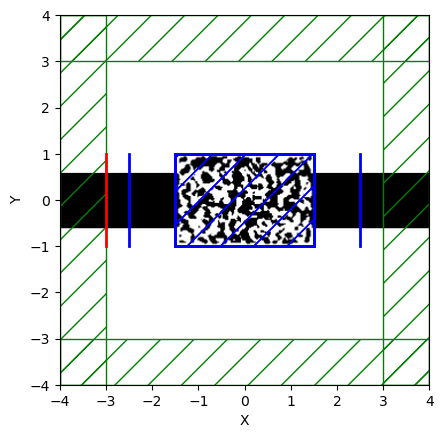

In [64]:
%matplotlib inline
plt.figure()
rho_vector = np.random.rand(Nx * Ny)
opt.update_design([mapping(rho_vector, 1e3, eta_i)])
opt.plot2D(True, output_plane=mp.Volume(center=(0, 0, 0), size=(12, 10, 0)))

Starting Minimax Optimization...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Iter: 00 | epigraph(t): 1.0000 | R(J1): 0.0013 | 1-T(J2): 0.9951
Starting forward run...
Starting adjoint run...
Calculating gradient...
Iter: 01 | epigraph(t): 0.9949 | R(J1): 0.0013 | 1-T(J2): 0.9948
Starting forward run...
Starting adjoint run...
Calculating gradient...
Iter: 02 | epigraph(t): 0.9921 | R(J1): 0.0014 | 1-T(J2): 0.9907
Starting forward run...
Starting adjoint run...
Calculating gradient...
Iter: 03 | epigraph(t): 0.9390 | R(J1): 0.0018 | 1-T(J2): 0.9701
Starting forward run...
Starting adjoint run...
Calculating gradient...
Iter: 04 | epigraph(t): 0.9683 | R(J1): 0.0029 | 1-T(J2): 0.9528
Starting forward run...
Starting adjoint run...
Calculating gradient...
Iter: 05 | epigraph(t): 0.7314 | R(J1): 0.0017 | 1-T(J2): 0.9914
Starting forward run...
Starting adjoint run...
Calculating gradient...
Iter: 06 | epigraph(t): 0.8626 | R(J1): 0.0053 | 1-T(J2): 0.9900
Starting

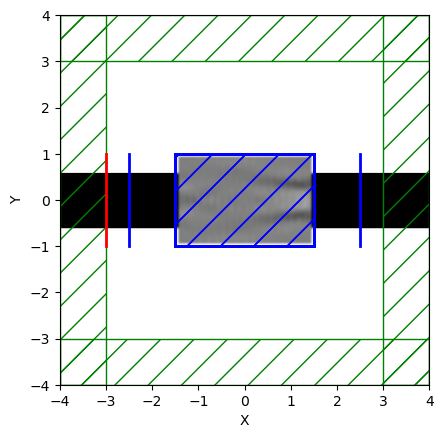

In [ ]:
cur_iter = [0]
evaluation_history = []
epivar_history = []

def vjp_mapping(x, g_mapped, beta, eta):
    g_mapped = npa.array(g_mapped)  # ensure autograd type

    def dot_map(z):
        return npa.sum(mapping(z, beta, eta) * g_mapped)

    # autograd gives gradient wrt z (same shape as x)
    return ag_grad(dot_map)(npa.array(x))

beta = 8

def obj_func(x_t, grad):
    t = x_t[0]
    if grad.size > 0:
        grad[0] = 1.0
        grad[1:] = 0.0
    return float(t)


# epigraph minimax
def constraint_func(result, x_t, grad):
    t = x_t[0]
    x = x_t[1:]

    mapped = mapping(x, beta, eta_i)
    f0, dJ_du = opt([mapped], need_gradient=(grad.size > 0))

    J1 = float(np.real(np.ravel(f0[0])[0]))
    J2 = float(np.real(np.ravel(f0[1])[0]))

    result[0] = J1 - t
    result[1] = J2 - t

    if grad.size > 0:
        # J1 gradient
        g_mapped_1 = np.ravel(dJ_du[0]).astype(float)
        g_x_1 = vjp_mapping(x, g_mapped_1, beta, eta_i)
        grad[0, 0] = -1.0  
        grad[0, 1:] = np.array(g_x_1, dtype=float)
        
        # J2 gradient
        g_mapped_2 = np.ravel(dJ_du[1]).astype(float)
        g_x_2 = vjp_mapping(x, g_mapped_2, beta, eta_i)
        grad[1, 0] = -1.0  
        grad[1, 1:] = np.array(g_x_2, dtype=float)

    print(f"Iter: {cur_iter[0]:02d} | epigraph(t): {t:.4f} | R(J1): {J1:.4f} | 1-T(J2): {J2:.4f}")

    evaluation_history.append((J1, J2))
    epivar_history.append(t)
    cur_iter[0] += 1

algorithm = nlopt.LD_MMA
n = Nx * Ny
maxeval = 20

solver = nlopt.opt(algorithm, n + 1)

lower_bounds = np.insert(np.zeros(n), 0, -float('inf'))
upper_bounds = np.insert(np.ones(n), 0, float('inf'))
solver.set_lower_bounds(lower_bounds)
solver.set_upper_bounds(upper_bounds)

solver.set_min_objective(obj_func)

tolerances = np.array([1e-6, 1e-6])
solver.add_inequality_mconstraint(constraint_func, tolerances)

solver.set_maxeval(maxeval)

x_t_0 = np.insert(x0, 0, 1.0)

print("Starting Minimax Optimization...")
x_t_opt = solver.optimize(x_t_0)

final_t = x_t_opt[0]
optimal_x = x_t_opt[1:]

opt.update_design([mapping(optimal_x, beta, eta_i)])
opt.plot2D(True)
plt.show()

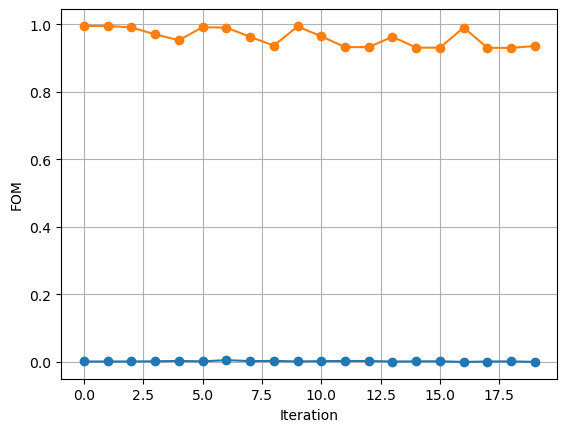

In [67]:
plt.figure()
plt.plot(evaluation_history, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()

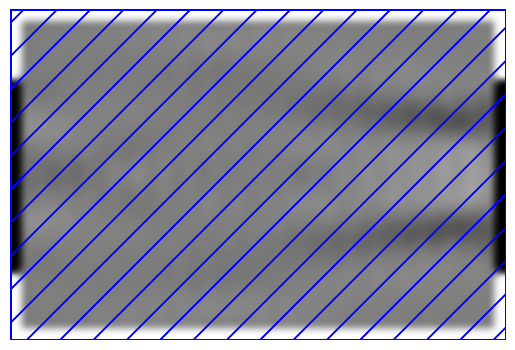

In [78]:
saved_sources = sim.sources
sim.sources = []

plt.figure()
sim.plot2D(
    output_plane=mp.Volume(
        center=design_region.center,
        size=design_region.size   # ← 이게 핵심
    ),
    labels=False
)
plt.axis("off")
plt.show()

sim.sources = saved_sources